# Gradient Descent & Backpropagation

Please read the required slides in `L05_gradient-descent_slides.pdf`. This notebook is a continuation of the Perceptron Basics notebook.
### Learning Aims
- Be confident in the internal workings of backpropagation through the application of gradient descent
- Use Pytorch to automatically backpropogate models.

In [1]:
! pip install numpy matplotlib torch pandas

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

### Is Gradient Descent = Backpropogation?
No.  
Aptly described by Wang Zerui, Gradient Descent is a process. This means there are many ways you can do it, all found in the `torch.optim` library, like SGD and Adam. On the other hand, backpropagation is just an algorithm, used to find the gradients for each weight.  
Its easy to confuse the two because they are so tightly intertwined - you cannot have any gradient descent algorithm without the gradient, which is from backpropagation. Still, the most important thing is to have an intuition of the concept - it's unlikely they will test you any of this anyways. To get a really good grasp of that intuition, watch [3Blue1Brown's Deep Learning series](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi), especially episodes DL2-DL4 (~45 mins total).  

### Implementing a Perceptron... again?
#### A differentiable Activation Function
The original perceptron has a piecewise activation function. What if we wanted something more real - lets say the logistic function - that will allow us to give non-binary outputs?  
This is where the backpropagation process kicks in. From the overall error, we need to find how each of the weights has contributed to the error, then correct for them (to what extent depends on your gradient descent algorithm).  
For this example, let's train the exact same perceptron as last notebook, but using the logistic function as the activation function. (Fun fact: it's no longer called a perceptron so let's call it a neuron)  
#### \_\_init\_\_, forward
These are equivalent in function to our previous perceptron in Perceptron Basics. Note that we use torch' functions now instead of numpy.
#### activation_func
This is the logistic/sigmoid function! 
#### netinput_func
This is `linear` in the previous notebook, now seperated into a seperate function.
#### backward
The first thing to understand before reading the code is the notation: grad_X_Y refers to the gradient of X with respect to Y, or dX/dY.  
Now, we need to backpropagate. For each weight, we want to find the gradient of the loss with respect to the weight - in other words, how the weight has influenced the loss. Given the equation `activate(Wx + b)`, you would have to do quite a bit of differentiation to get to the equations below. I would include the equations if I knew how to use Latex, but now it can only be left as a highly highly recommended exercise for the reader. Once you do that, all the equations will immediately make sense (and you want to feel like you understand fully, don't you?)  
  
Note that our loss function is simply MSE (the one that comes out when you Google it!)

In [3]:
class NeuronModel():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1,
                                   dtype=torch.float)
        self.bias = torch.zeros(1, dtype=torch.float)

    def activation_func(self, x): 
        return 1. / (1. + torch.exp(-x)) # This is the logistic function!

    def netinput_func(self, x, w, b):
         return torch.add(torch.mm(x, w), b)

    def forward(self, x):
        netinputs = self.netinput_func(x, self.weights, self.bias)
        activations = self.activation_func(netinputs)
        return activations.view(-1)

    def backward(self, x, yhat, y):
        # note that here, "yhat" are the "activations"
        netinputs = self.netinput_func(x, self.weights, self.bias)

        grad_loss_yhat = 2 * (yhat - y) / y.size(0)
        grad_yhat_bias = torch.mm(self.activation_func(netinputs).t(), (1 - self.activation_func(netinputs)))
        grad_yhat_weights = torch.mm(self.activation_func(netinputs).t(), (1 - self.activation_func(netinputs))) * x
        grad_loss_weights = (torch.matmul(grad_yhat_weights.t(), grad_loss_yhat.view(-1, 1)))
        grad_loss_bias = torch.sum(grad_yhat_bias * grad_loss_yhat)

        return (-1)*grad_loss_weights, (-1)*grad_loss_bias

It's really not worth it to analyse the training and evaluation code here because Pytorch completely changes the game the moment it's used to its fullest potential.

In [4]:
! wget https://raw.githubusercontent.com/rasbt/stat479-deep-learning-ss19/refs/heads/master/hw2/datasets/iris.data

--2025-01-31 20:01:15--  https://raw.githubusercontent.com/rasbt/stat479-deep-learning-ss19/refs/heads/master/hw2/datasets/iris.data
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
185.199.109.133, 185.199.110.133, 185.199.111.133, ...tent.com)... 
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
200 OKequest sent, awaiting response... 
Length: 4551 (4.4K) [text/plain]
Saving to: ‘iris.data.2’

iris.data.2         100%[===================>]   4.44K  --.-KB/s    in 0s      

2025-01-31 20:01:15 (91.9 MB/s) - ‘iris.data.2’ saved [4551/4551]



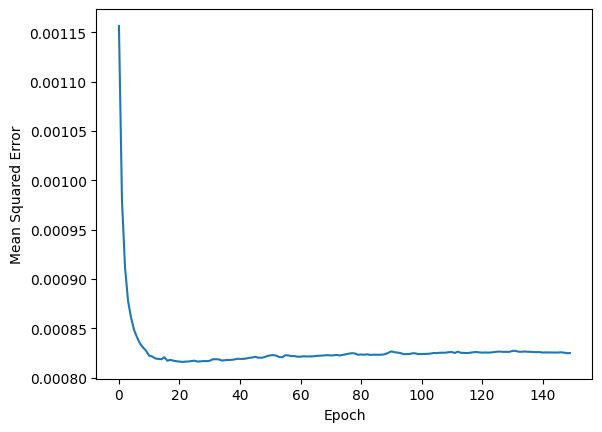

Weights tensor([[-0.8182],
        [ 5.9014]])
Bias tensor([0.1258])
Training Accuracy: 91.43
Test Accuracy: 96.67


In [5]:
df = pd.read_csv('./iris.data', index_col=None, header=None)
df.columns = ['x1', 'x2', 'x3', 'x4', 'y']
df = df.iloc[50:150]
df['y'] = df['y'].apply(lambda x: 0 if x == 'Iris-versicolor' else 1)

# Assign features and target
X = torch.tensor(df[['x2', 'x3']].values, dtype=torch.float)
y = torch.tensor(df['y'].values, dtype=torch.int)

# Shuffling & train/test split
torch.manual_seed(123)
shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)

X, y = X[shuffle_idx], y[shuffle_idx]

percent70 = int(shuffle_idx.size(0)*0.7)

X_train, X_test = X[shuffle_idx[:percent70]], X[shuffle_idx[percent70:]]
y_train, y_test = y[shuffle_idx[:percent70]], y[shuffle_idx[percent70:]]

# Normalize (mean zero, unit variance)
mu, sigma = X_train.mean(dim=0), X_train.std(dim=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma


def loss(yhat, y):
    return torch.mean((yhat - y)**2) / y.size(0)

def train(model, x, y, num_epochs,
          learning_rate=0.01, seed=123, minibatch_size=10):
    cost = []

    torch.manual_seed(seed)
    for e in range(num_epochs):

        #### Shuffle epoch
        shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)
        minibatches = torch.split(shuffle_idx, minibatch_size)

        for minibatch_idx in minibatches:

            #### Compute outputs ####
            yhat = model.forward(x[minibatch_idx])

            #### Compute gradients ####
            negative_grad_w, negative_grad_b = \
                model.backward(x[minibatch_idx], yhat, y[minibatch_idx])

            #### Update weights ####
            model.weights += learning_rate * negative_grad_w
            model.bias += learning_rate * negative_grad_b


        #### Logging ####
        yhat = model.forward(x)
        curr_loss = loss(yhat, y)
        # print('Epoch: %03d' % (e+1), end="")
        # print(' | MSE: %.5f' % curr_loss)
        cost.append(curr_loss)

    return cost

model = NeuronModel(num_features=X_train.size(1))
cost = train(model,
             X_train, y_train.float(),
             num_epochs=150,
             learning_rate=0.5,
             seed=123,
             minibatch_size=10)

plt.plot(range(len(cost)), cost)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

print('Weights', model.weights)
print('Bias', model.bias)

def custom_where(cond, x_1, x_2):
    return (cond * x_1) + ((~cond) * x_2)

train_pred = model.forward(X_train)
train_acc = torch.mean(
    (custom_where(train_pred > 0.5, 1, 0).int() == y_train).float())

test_pred = model.forward(X_test)
test_acc = torch.mean(
    (custom_where(test_pred > 0.5, 1, 0).int() == y_test).float())

print('Training Accuracy: %.2f' % (train_acc*100))
print('Test Accuracy: %.2f' % (test_acc*100))

### Using Pytorch for Backpropagation
> I hate maths, so I use the code to get rid of all the maths  
> ~ Mr Lim Cheng Chong (2024), probably

The entire differentiation nonsense can be forgotten if we just use `torch.grad`. Observe as we completely remove the backwards function.  
#### \_\_init\_\_
Note the addition of `required_grad=True` in the definitions for the weights and bias.
#### activation_func, netinput_func, forward
Completely unchanged!

In [6]:
class AutoNeuronModel():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1,
                                   dtype=torch.float,
                                   requires_grad=True)
        self.bias = torch.zeros(1, dtype=torch.float,
                                requires_grad=True)

    def activation_func(self, x): 
        return 1. / (1. + torch.exp(-x)) # This is the logistic function!

    def netinput_func(self, x, w, b):
         return torch.add(torch.mm(x, w), b)

    def forward(self, x):
        netinputs = self.netinput_func(x, self.weights, self.bias)
        activations = self.activation_func(netinputs)
        return activations.view(-1)

Now, we can finally go through the training and testing code.
#### loss_func
It's just an implementation of MSE loss. Nothing much, in fact we can replace it with proper torch functions when we get to that part later on.
#### train
For each epoch, split into minibatches of 10. `torch.randperm(n)` returns a random permutations of the natural numbers from 1 to n. In this case, we use it to shuffle the dataset before splitting it into minibatches.  
For each batch, 
- Pass the batch into the model
- Compute the loss. Note that so far, all calculations have been done via torch functions on torch tensors, which allow us to...
- Use the grad function to automatically backpropogate the gradients for the weights and biases!
- Modify the weights and biases. Here we just multiply the gradient by a learning rate and add it, similar to SGD.
Finally, in each epoch, calculate the loss for logging.

In [7]:
from torch.autograd import grad

In [8]:
def loss_func(yhat, y):
    return torch.mean((yhat - y)**2) / y.size(0)

def train(model, x, y, num_epochs,
          learning_rate=0.01, seed=123, minibatch_size=10):
    cost = []
    
    torch.manual_seed(seed)
    for e in range(num_epochs):
        
        #### Shuffle epoch
        shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)
        minibatches = torch.split(shuffle_idx, minibatch_size)
        
        for minibatch_idx in minibatches:

            #### Compute outputs ####
            yhat = model.forward(x[minibatch_idx])
            loss = loss_func(yhat, y[minibatch_idx])
            
            #### Compute gradients ####
            
            negative_grad_w = grad(loss, model.weights, retain_graph=True)[0] * (-1)
            negative_grad_b = grad(loss, model.bias)[0] * (-1)

            model.weights = model.weights + learning_rate * negative_grad_w
            model.bias = model.bias + learning_rate * negative_grad_b

        #### Logging ####
        with torch.no_grad():
            # context manager to
            # avoid building graph during "inference"
            # to save memory
            yhat = model.forward(x)
            curr_loss = loss_func(yhat, y)
            # print('Epoch: %03d' % (e+1), end="")
            # print(' | MSE: %.5f' % curr_loss)
            cost.append(curr_loss)

    return cost

Let's run the model. Using about the same parameters as previously, the result is, unsurprisngly, about the same.

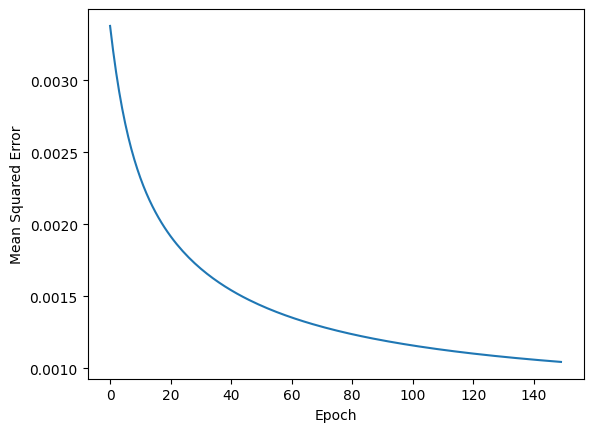

Weights tensor([[-0.2389],
        [ 2.3572]], grad_fn=<AddBackward0>)
Bias tensor([-0.0184], grad_fn=<AddBackward0>)
Training Accuracy: 90.00
Test Accuracy: 96.67


In [9]:
model = AutoNeuronModel(num_features=X_train.size(1))
cost = train(model,
             X_train, y_train.float(),
             num_epochs=150,
             learning_rate=0.5,
             seed=123,
             minibatch_size=10)

plt.plot(range(len(cost)), cost)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

print('Weights', model.weights)
print('Bias', model.bias)

def custom_where(cond, x_1, x_2):
    return (cond * x_1) + ((~cond) * x_2)

train_pred = model.forward(X_train)
train_acc = torch.mean(
    (custom_where(train_pred > 0.5, 1, 0).int() == y_train).float())

test_pred = model.forward(X_test)
test_acc = torch.mean(
    (custom_where(test_pred > 0.5, 1, 0).int() == y_test).float())

print('Training Accuracy: %.2f' % (train_acc*100))
print('Test Accuracy: %.2f' % (test_acc*100))

### Further Reading
From here, if you're interested in how gradient descent works, jump straight into Deep Learning and go learn about the different gradient descent algorithms like SGD, Adam etc.. Otherwise, if you just want to keep learning the basics and get familiar with the basics before letting Pytorch take control of everything, continue onto the next topics here.

### Sources
- https://github.com/rasbt/stat479-deep-learning-ss19/blob/master/hw2/hw2.ipynb